In [16]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def partial_spearman_corr(df, x, y, controls):
    """Compute partial Spearman correlation between x and y given selected control variables."""
    from statsmodels.api import OLS, add_constant
    
    if controls:
        # Regress x and y on control variables
        residual_x = OLS(df[x], add_constant(df[controls])).fit().resid
        residual_y = OLS(df[y], add_constant(df[controls])).fit().resid
        return spearmanr(residual_x, residual_y)[0]
    else:
        return spearmanr(df[x], df[y])[0]

def plot_causal_graph(adj_matrix, df):
    """
    Plots causal graph with edge color based on partial Spearman correlation signs.
    Uses only relevant control variables.
    """
    nodes = df.columns
    G = nx.DiGraph()
    edge_info = []

    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if adj_matrix[i, j] != 0:
                cause = nodes[i]
                effect = nodes[j]
                
                # Identify control variables (parents of cause or effect)
                related_vars = [nodes[k] for k in range(len(nodes)) if adj_matrix[k, j] or adj_matrix[k, i]]
                controls = [var for var in related_vars if var not in [cause, effect]]

                # Compute partial Spearman correlation
                pcorr = partial_spearman_corr(df, cause, effect, controls)

                # Determine edge color and width
                edge_color = 'red' if pcorr > 0 else 'blue'
                edge_width = 1 + 3 * abs(pcorr)

                G.add_edge(cause, effect, weight=pcorr)
                edge_info.append((cause, effect, edge_color, edge_width))

    # Layout & Plot
    pos = nx.circular_layout(G)
    label_pos = {n: (p[0] * 1.3, p[1] * 1.3) for n, p in pos.items()}

    plt.figure(figsize=(10, 10))
    
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', edgecolors='black', node_size=500, alpha=0.9)
    nx.draw_networkx_labels(G, label_pos, font_size=10, font_weight='bold', font_color='black')

    # Draw edges
    arc_rad = 0.1
    for u, v, color, width in edge_info:
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, edge_color=color,
                               arrowstyle='->', arrowsize=20, connectionstyle=f'arc3,rad={arc_rad}',
                               min_source_margin=10, min_target_margin=10)

    plt.title("Causal Graph with Edge Sign (Partial Spearman Correlation)", fontsize=14)
    plt.gca().margins(x=0.3, y=0.3)
    plt.axis('equal')
    plt.show()

In [255]:
import numpy as np
import pandas as pd
from pc_gcastle import PC
from random import shuffle
def run_pc_analysis(df, factor_list, alpha=0.05, shuffle_factors=False):
    """
    Run PC algorithm for a selected subset of factors.
    
    Parameters:
        df (pd.DataFrame): Original dataframe containing 'factor', 'cbsacode', and 'SSAMI'.
        factor_list (list): List of factor names to include in the analysis.
        alpha (float): Significance level for conditional independence tests.
        shuffle_factors (bool): Whether to shuffle the factor list randomly.
    
    Returns:
        pc (PC object): The trained PC model.
    """
    
    if shuffle_factors:
        shuffle(factor_list)
    
    # Filter and pivot
    df_select = df.loc[df['factor'].isin(factor_list)]
    dfp = df_select.pivot(index=["cbsacode",'year'], columns="factor", values="SSAMI_d").reset_index()
    df_cleaned = dfp.drop(columns=["cbsacode",'year'])  # Reverse column order as in original code
    data_matrix = df_cleaned.to_numpy()

    # Run PC algorithm
    pc = PC(variant='stable', alpha=alpha, ci_test='spearman')
    pc.learn(data_matrix, columns=df_cleaned.columns)
    
    print("Learned skeleton (CPDAG):")
    plot_causal_graph(pc.causal_matrix, df_cleaned)
    
    return pc

In [195]:
import pandas as pd

In [251]:
df = pd.read_csv('detrend_result.csv')

In [252]:
df

,cbsacode,year,factor,SSAMI_d,METHOD
0,10740,2011,adult_obesity,-0.255189,arima
1,10740,2011,adult_smoking,-0.130169,arima
2,10740,2011,children_in_single-parent_households,0.266437,original
3,10740,2011,depressed,0.132643,arima
4,10740,2011,diabetes_prevalence,-0.006633,linear
...,...,...,...,...,...
16411,49340,2022,rural,0.200309,arima
16412,49340,2022,sexually_transmitted_infections,-0.147637,original
16413,49340,2022,some_college,-0.001853,linear
16414,49340,2022,unemployment,0.138385,arima


In [253]:
df['factor'].unique()

array(['adult_obesity', 'adult_smoking',
       'children_in_single-parent_households', 'depressed',
       'diabetes_prevalence', 'driving_alone_to_work',
       'excessive_drinking', 'gdp', 'low_birthweight',
       'median_household_income', 'mental_health_providers',
       'not_proficient_in_english', 'poor_or_fair_health',
       'primary_care_physicians', 'rural',
       'sexually_transmitted_infections', 'some_college', 'unemployment',
       'uninsured_adults'], dtype=object)

Learned skeleton (CPDAG):


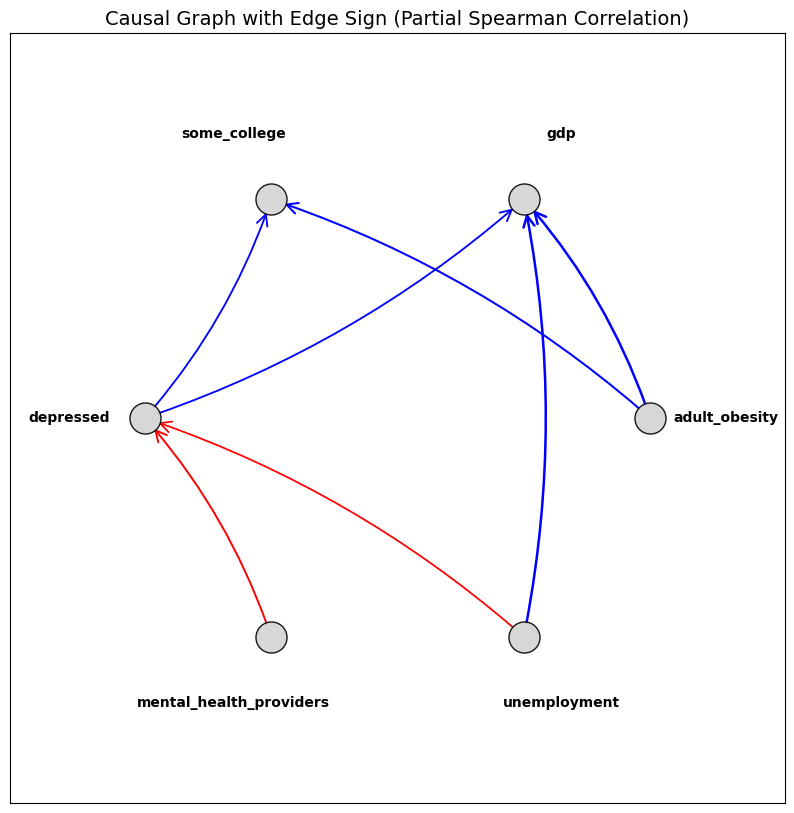

In [278]:
my_factors = [
    'adult_obesity', 
              # 'adult_smoking',
      #  'children_in_single-parent_households', 
       'depressed',
      #  'diabetes_prevalence',
        #  'driving_alone_to_work',
      #  'excessive_drinking', 
       'gdp', 
      #  'low_birthweight',
      #  'median_household_income', 
       'mental_health_providers',
      #  'not_proficient_in_english', 
      # 'poor_or_fair_health',
      #  'primary_care_physicians', 'rural',
      #  'sexually_transmitted_infections',
         'some_college', 
         'unemployment',
      #  'uninsured_adults'
]

pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.05, shuffle_factors=True)

Learned skeleton (CPDAG):


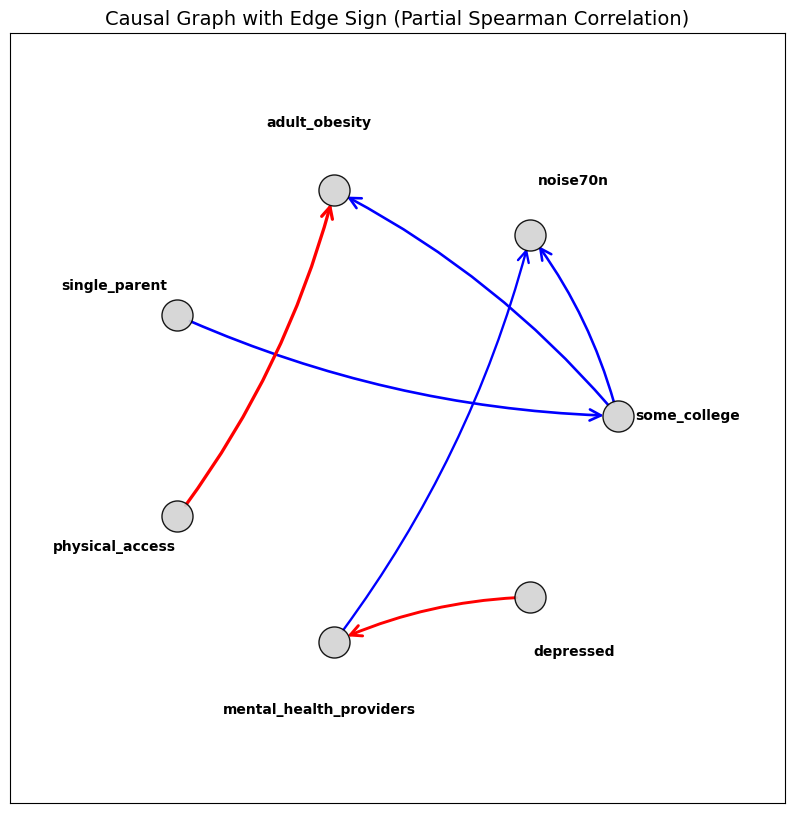

In [163]:
my_factors = [
    'median_household_income','adult_obesity','noise70n',
    'depressed','mental_health_providers','some_college',
    'single_parent','physical_access'#,'suicide'
]

pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.05, shuffle_factors=True)

In [41]:
df['factor'].unique()

array(['depressed', 'suicide', 'some_college', 'single_parent',
       'driving_alone', 'median_household_income',
       'mental_health_providers', 'social_associations', 'unemployment',
       'noise70n', 'Park_Area_Acres', 'Weighted_RESP',
       'adult_excessive_drinking', 'adult_obesity', 'physical_access',
       'adult_smoking', 'adult_sti', 'adult_diabetes_prevalence',
       'health_pca'], dtype=object)

Learned skeleton (CPDAG):


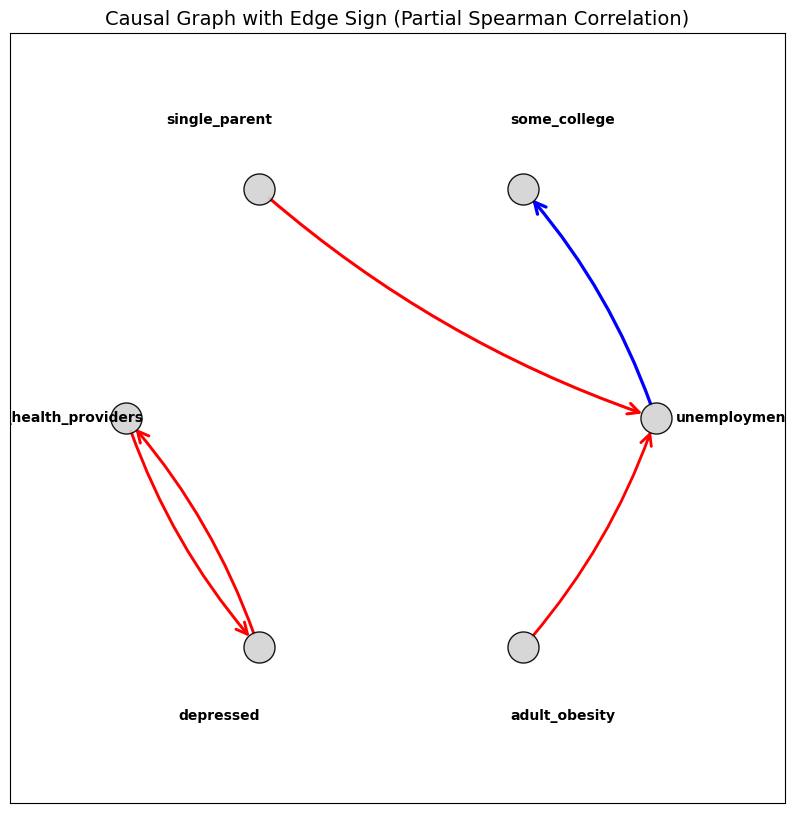

In [184]:
my_factors = ['depressed', 'some_college', 'single_parent',
       'mental_health_providers', 'social_associations', 'unemployment',
       'Park_Area_Acres', 'Weighted_RESP', 'adult_obesity',
       'adult_smoking'
]

pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.05, shuffle_factors=True)

Learned skeleton (CPDAG):


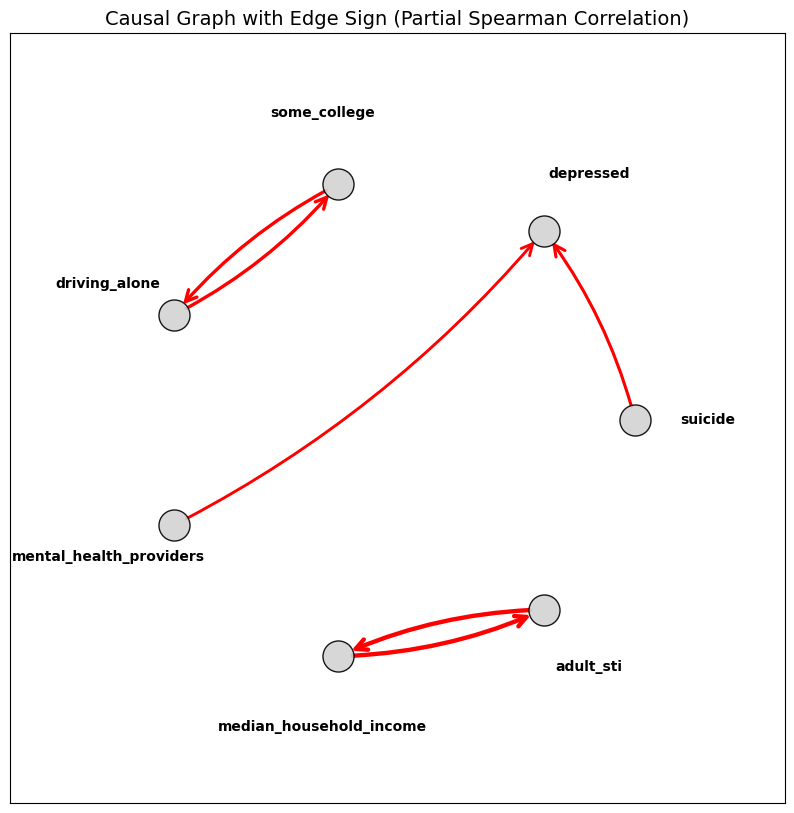

In [167]:
my_factors = ['depressed', 'suicide', 'some_college', 'single_parent',
       'driving_alone', 'median_household_income',
       'mental_health_providers', 
       'noise70n', 'Park_Area_Acres', 'Weighted_RESP', 
       'adult_smoking', 'adult_sti'
       ]

pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.01, shuffle_factors=True)

In [241]:
dfp

factor,cbsacode,year,Park_Area_Acres,Weighted_RESP,adult_obesity,adult_smoking,children_eligible_for_free_or_reduced_price_lunch,children_in_poverty,children_in_single_parent_households,depressed,...,poor_physical_health_days,premature_death,preventable_hospital_stays,primary_care_physicians,rural,sexually_transmitted_infections,some_college,unemployment,uninsured_adults,violent_crime
0,10740.0,2011,-0.438079,-0.547852,-0.230028,-0.016582,0.130130,-0.224445,0.189277,-0.188075,...,0.369435,-0.188931,0.025941,0.162565,-0.426485,-0.064472,0.199744,0.122076,0.647431,NaN
1,10740.0,2012,-0.415192,-0.547852,-0.335447,-0.141340,0.245807,-0.139694,0.199380,-0.214462,...,0.365514,-0.184033,0.016127,0.161725,-0.426485,0.016037,0.124675,0.254075,0.452958,0.457532
2,10740.0,2013,-0.456462,-0.549159,-0.340474,-0.081933,0.279182,-0.084522,0.200258,-0.279396,...,0.370129,-0.262118,-0.063308,0.048848,-0.411119,0.151049,0.138128,0.211637,0.425726,0.408250
3,10740.0,2014,-0.453057,-0.548865,-0.312738,-0.029383,0.234171,-0.178664,0.205192,-0.173811,...,0.384453,-0.212762,-0.029388,0.103795,-0.415892,-0.083509,0.141795,0.275926,0.487585,0.419032
4,10740.0,2015,-0.467894,-0.548477,-0.341716,-0.100690,0.273996,-0.051951,0.220825,-0.280372,...,0.382347,-0.306155,0.000614,0.084047,-0.421930,-0.050364,0.087747,0.329508,0.426053,0.394306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,49340.0,2018,-0.194505,-0.180550,-0.318312,0.065484,NaN,-0.414717,0.003279,-0.067214,...,0.002819,-0.010488,0.690992,0.012699,0.114302,-0.319410,0.027401,-0.205341,-1.119941,0.438076
860,49340.0,2019,-0.213661,-0.180567,-0.354920,0.066602,NaN,-0.289368,0.029679,-0.017938,...,0.004721,-0.001488,0.634661,-0.004657,0.105223,-0.232611,-0.000254,-0.128877,-1.028964,0.320264
861,49340.0,2020,-0.240287,-0.180548,-0.362704,-0.052276,NaN,-0.378483,0.013226,-0.074102,...,0.049566,0.048686,0.652360,-0.009856,0.085551,-0.291849,0.032484,-0.143217,-0.985201,0.356601
862,49340.0,2021,-0.249823,-0.180284,-0.335709,0.067210,NaN,-0.203104,-0.016876,-0.024803,...,0.011559,-0.021198,0.625004,0.010086,0.075102,-0.247321,0.068310,-0.207662,-1.007847,0.328471


In [244]:
df_cleaned

factor,cbsacode,year,Park_Area_Acres,Weighted_RESP,adult_obesity,adult_smoking,children_eligible_for_free_or_reduced_price_lunch,children_in_poverty,children_in_single_parent_households,depressed,...,poor_or_fair_health,poor_physical_health_days,premature_death,preventable_hospital_stays,primary_care_physicians,rural,sexually_transmitted_infections,some_college,unemployment,uninsured_adults
0,10740.0,2011,-0.438079,-0.547852,-0.230028,-0.016582,0.130130,-0.224445,0.189277,-0.188075,...,0.009198,0.369435,-0.188931,0.025941,0.162565,-0.426485,-0.064472,0.199744,0.122076,0.647431
1,10740.0,2012,-0.415192,-0.547852,-0.335447,-0.141340,0.245807,-0.139694,0.199380,-0.214462,...,0.013465,0.365514,-0.184033,0.016127,0.161725,-0.426485,0.016037,0.124675,0.254075,0.452958
2,10740.0,2013,-0.456462,-0.549159,-0.340474,-0.081933,0.279182,-0.084522,0.200258,-0.279396,...,-0.037889,0.370129,-0.262118,-0.063308,0.048848,-0.411119,0.151049,0.138128,0.211637,0.425726
3,10740.0,2014,-0.453057,-0.548865,-0.312738,-0.029383,0.234171,-0.178664,0.205192,-0.173811,...,-0.040948,0.384453,-0.212762,-0.029388,0.103795,-0.415892,-0.083509,0.141795,0.275926,0.487585
4,10740.0,2015,-0.467894,-0.548477,-0.341716,-0.100690,0.273996,-0.051951,0.220825,-0.280372,...,-0.051081,0.382347,-0.306155,0.000614,0.084047,-0.421930,-0.050364,0.087747,0.329508,0.426053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,49340.0,2018,-0.194505,-0.180550,-0.318312,0.065484,NaN,-0.414717,0.003279,-0.067214,...,0.052007,0.002819,-0.010488,0.690992,0.012699,0.114302,-0.319410,0.027401,-0.205341,-1.119941
860,49340.0,2019,-0.213661,-0.180567,-0.354920,0.066602,NaN,-0.289368,0.029679,-0.017938,...,0.050458,0.004721,-0.001488,0.634661,-0.004657,0.105223,-0.232611,-0.000254,-0.128877,-1.028964
861,49340.0,2020,-0.240287,-0.180548,-0.362704,-0.052276,NaN,-0.378483,0.013226,-0.074102,...,-0.004642,0.049566,0.048686,0.652360,-0.009856,0.085551,-0.291849,0.032484,-0.143217,-0.985201
862,49340.0,2021,-0.249823,-0.180284,-0.335709,0.067210,NaN,-0.203104,-0.016876,-0.024803,...,-0.029176,0.011559,-0.021198,0.625004,0.010086,0.075102,-0.247321,0.068310,-0.207662,-1.007847


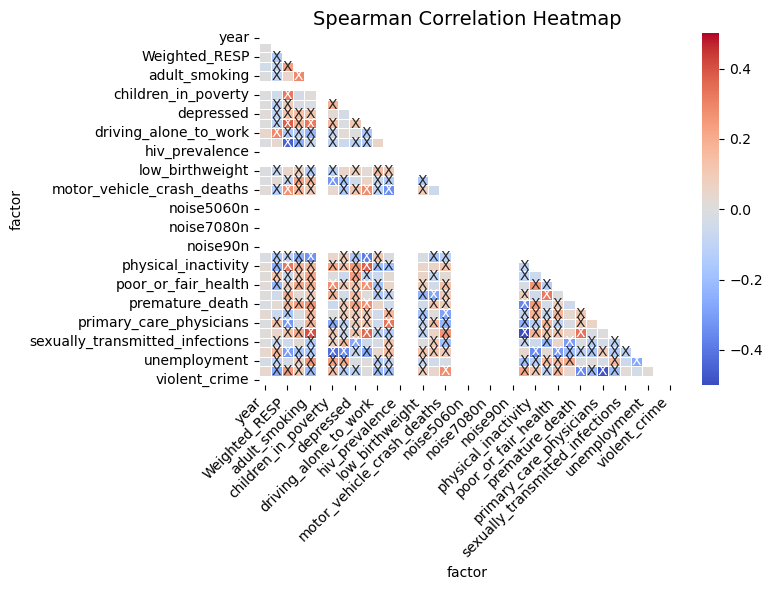

In [245]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the dataframe
dfp = df.pivot(index=["cbsacode",'year'], columns="factor", values="SSAMI_d").reset_index()
df_cleaned = dfp.copy()

# Define factor list (excluding index column if present)
factor_list = df_cleaned.columns.drop('cbsacode', errors='ignore')  

# Initialize correlation and p-value matrices
spearman_corr = pd.DataFrame(index=factor_list, columns=factor_list, dtype=float)
p_values = pd.DataFrame(index=factor_list, columns=factor_list, dtype=float)

# Compute Spearman correlations
for f1, f2 in itertools.combinations(factor_list, 2):
    corr, p_value = spearmanr(df_cleaned[f1], df_cleaned[f2])
    spearman_corr.loc[f1, f2] = spearman_corr.loc[f2, f1] = corr
    p_values.loc[f1, f2] = p_values.loc[f2, f1] = p_value

# Fill diagonals
np.fill_diagonal(spearman_corr.values, 1)
np.fill_diagonal(p_values.values, 1)

# Create annotation matrix
annot_matrix = np.where(p_values.to_numpy() <= 0.05, 'X', '')

# Mask for upper triangle
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr.astype(float), annot=annot_matrix, mask=mask,
            cmap="coolwarm", vmin=-0.5, vmax=0.5, fmt="", linewidths=0.5, cbar=True)

plt.title("Spearman Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [125]:
df_cleaned

factor,unemployment,suicide,some_college,social_associations,single_parent,physical_access,noise70n,mental_health_providers,median_household_income,health_pca,driving_alone,depressed,adult_sti,adult_smoking,adult_obesity,adult_excessive_drinking,adult_diabetes_prevalence,Weighted_RESP,Park_Area_Acres,cbsacode
0,0.259455,-0.018385,-0.086131,-8.647446e-07,0.289256,-0.004021,0.868742,0.409572,0.018044,5.714567,-0.038890,0.103655,0.315699,0.120002,-0.126914,-0.008491,0.040265,-0.015597,-0.744463,10740
1,0.190902,-0.030856,0.092735,-6.706471e-07,-0.136276,0.080169,-3.731388,0.414006,-0.657471,12.126948,-0.058087,-0.202691,-0.484830,-0.020074,0.030962,0.217990,-0.118175,-0.016470,3.331501,11260
2,0.022540,-0.003900,0.011432,9.303954e-07,0.020388,0.454803,0.766646,-0.110429,0.521230,-1.312746,0.039741,-0.118223,0.818965,0.428573,0.495718,0.439306,0.476741,-0.000703,-0.151473,12060
3,0.128995,-0.052560,-0.074841,-2.261422e-07,0.198081,-0.182118,-0.175962,-0.063261,0.260436,-4.319615,-0.053592,-0.094521,0.160658,-0.074845,-0.017904,-0.053782,0.104967,-0.036916,-0.611291,12260
4,-0.074798,0.064764,0.293661,-4.200232e-07,-0.344886,-0.090087,-0.375127,-0.015885,-0.022458,2.396649,0.005229,-0.056843,0.065412,-0.166990,-0.364877,0.124824,-0.507320,-0.061818,1.326678,12420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.171629,0.014015,-0.110264,9.330374e-07,-0.093345,0.062393,0.023538,0.177713,0.443269,-2.777601,-0.064547,0.020999,0.230177,0.071739,0.161539,0.053054,0.169483,0.007104,-0.515335,45820
68,0.001504,0.095280,-0.105864,-2.103814e-07,0.047760,-0.079996,0.051525,0.618630,0.047670,-1.079003,-0.025657,0.210277,0.047576,0.041423,-0.008000,-0.081407,0.047613,0.014528,-0.410308,46140
69,-0.107209,-0.031655,0.114490,-5.443947e-07,0.167208,-0.027494,-1.989421,-0.273355,0.626579,-4.901460,0.102905,-0.038528,0.928063,0.010265,-0.014229,0.073670,-0.093459,-0.011947,0.790423,47260
70,0.110604,0.101990,-0.017608,-2.297330e-07,0.057370,0.006152,-0.368799,-0.023090,-0.122775,NaN,0.000467,0.008298,-0.387958,0.051909,0.036500,0.045092,0.016698,0.029388,-0.237277,48620


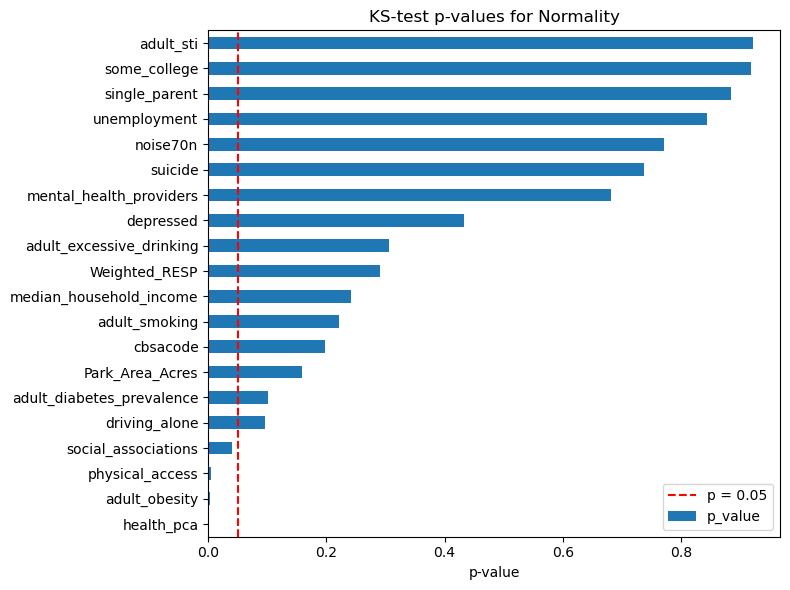

In [126]:
from scipy.stats import kstest, zscore
import pandas as pd

# Assume your data is in a dataframe called df_factors (like in the image)
# Example: df_factors = df.drop(columns="factor") if "factor" is just index

ks_results = {}

# Loop through each column and perform KS test after z-score normalization
for col in df_cleaned.columns:
    data = df_cleaned[col].dropna()  # Drop NaNs if any
    standardized_data = zscore(data)  # Standardize to mean 0, std 1
    stat, p_value = kstest(standardized_data, 'norm')  # Test against N(0,1)
    ks_results[col] = {"KS_statistic": stat, "p_value": p_value}

# Convert to DataFrame for display
ks_df = pd.DataFrame(ks_results).T
ks_df["normal"] = ks_df["p_value"] > 0.05  # True if fails to reject normality

import matplotlib.pyplot as plt

# Optional: plot the p-values
ks_df["p_value"].sort_values().plot(kind="barh", figsize=(8,6))
plt.axvline(x=0.05, color='red', linestyle='--', label='p = 0.05')
plt.title("KS-test p-values for Normality")
plt.xlabel("p-value")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_cleaned= df_cleaned.drop

factor,unemployment,suicide,some_college,social_associations,single_parent,physical_access,noise70n,mental_health_providers,median_household_income,health_pca,driving_alone,depressed,adult_sti,adult_smoking,adult_obesity,adult_excessive_drinking,adult_diabetes_prevalence,Weighted_RESP,Park_Area_Acres,cbsacode
0,0.259455,-0.018385,-0.086131,-8.647446e-07,0.289256,-0.004021,0.868742,0.409572,0.018044,5.714567,-0.038890,0.103655,0.315699,0.120002,-0.126914,-0.008491,0.040265,-0.015597,-0.744463,10740
1,0.190902,-0.030856,0.092735,-6.706471e-07,-0.136276,0.080169,-3.731388,0.414006,-0.657471,12.126948,-0.058087,-0.202691,-0.484830,-0.020074,0.030962,0.217990,-0.118175,-0.016470,3.331501,11260
2,0.022540,-0.003900,0.011432,9.303954e-07,0.020388,0.454803,0.766646,-0.110429,0.521230,-1.312746,0.039741,-0.118223,0.818965,0.428573,0.495718,0.439306,0.476741,-0.000703,-0.151473,12060
3,0.128995,-0.052560,-0.074841,-2.261422e-07,0.198081,-0.182118,-0.175962,-0.063261,0.260436,-4.319615,-0.053592,-0.094521,0.160658,-0.074845,-0.017904,-0.053782,0.104967,-0.036916,-0.611291,12260
4,-0.074798,0.064764,0.293661,-4.200232e-07,-0.344886,-0.090087,-0.375127,-0.015885,-0.022458,2.396649,0.005229,-0.056843,0.065412,-0.166990,-0.364877,0.124824,-0.507320,-0.061818,1.326678,12420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.171629,0.014015,-0.110264,9.330374e-07,-0.093345,0.062393,0.023538,0.177713,0.443269,-2.777601,-0.064547,0.020999,0.230177,0.071739,0.161539,0.053054,0.169483,0.007104,-0.515335,45820
68,0.001504,0.095280,-0.105864,-2.103814e-07,0.047760,-0.079996,0.051525,0.618630,0.047670,-1.079003,-0.025657,0.210277,0.047576,0.041423,-0.008000,-0.081407,0.047613,0.014528,-0.410308,46140
69,-0.107209,-0.031655,0.114490,-5.443947e-07,0.167208,-0.027494,-1.989421,-0.273355,0.626579,-4.901460,0.102905,-0.038528,0.928063,0.010265,-0.014229,0.073670,-0.093459,-0.011947,0.790423,47260
70,0.110604,0.101990,-0.017608,-2.297330e-07,0.057370,0.006152,-0.368799,-0.023090,-0.122775,NaN,0.000467,0.008298,-0.387958,0.051909,0.036500,0.045092,0.016698,0.029388,-0.237277,48620


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your dataframe (replace df_filtered with your actual dataframe name)


# Compute Variance Inflation Factor (VIF)
#X = sm.add_constant(df)  # Add a constant for intercept
vif_data = pd.DataFrame()
vif_data["Feature"] = df_cleaned.columns
vif_data["VIF"] = [variance_inflation_factor(df_cleaned.values, i) for i in range(df_cleaned.shape[1])]

styled_table = (
    vif_data.style
    .set_caption("Variance Inflation Factor (VIF)")
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]}
    ])
    .set_properties(**{'text-align': 'center'})
)

# Display the table
styled_table

# per captia

MissingDataError: exog contains inf or nans